# **Optical Conveyor Belt Transport Calculations for Rb and Cs Atoms**

Replicate results for optical transport of bulk gases of ultracold Rb and Cs atoms from S. Cornish group.<br/>
References: **A.J. Matthies et al, PRA (2024)** and **A.J. Matthies PhD Thesis, Durham University (2023)**<br/>

Note here that "Actual" cleans up the calculations and comments on them.<br/>
"Practice" (other Jupyter notebook) goes into more detail in some areas and is not as organized.

# Import Relevant Packages and Constants

In [85]:
#import relevant Python packages, special functions, and constants
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import epsilon_0, mu_0, c, k, g, physical_constants
from scipy.special import ellipk, ellipe
from scipy.optimize import curve_fit

# Define Relevant Parameters for RbCs Experiment.

In [86]:
#define relevant parameters for RbCs experiment (Rb and Cs atoms)

L = 37.2e-2 #length of conveyor belt in m
lam = 1064e-9 #wavelength of light in m
P = 18 #power of light in W
w0 = 180e-6 #waist of light in m
x0 = 5.5e-2 #focus position in m
bohr_rad = physical_constants['Bohr radius'][0] #Bohr radius in m
amu = physical_constants['atomic mass constant'][0] #atomic mass unit in kg
alpha_Cs = 1162 * 4*np.pi*epsilon_0 * bohr_rad**3 #polarizability of Cs
alpha_Rb = 687 * 4*np.pi*epsilon_0 * bohr_rad**3 #polarizability of Rb
m_Cs = 133 * amu #mass of Cs in kg
m_Rb = 87 * amu #mass of Rb in kg

# Define Parameters for Gaussian Laser Beam

In [87]:
#define relevant functions for a Gaussian laser beam
#x is position along beam axis. w0 is beam waist. 
#x0 is focal point. lam is wavelength. P is power. 
#y and z are transverse coordinates.

def w(x,w0,x0,lam):
    xR = np.pi * w0**2 / lam
    return w0 * np.sqrt(1 + ((x-x0) / xR)**2)

def I0(P,x,w0,x0,lam):
    return 2 * P / (np.pi * w(x,w0,x0,lam)**2)

def gaussian_beam_intensity(x,x0,y,z,w0,lam,P):
    intensity = I0(P,x,w0,x0,lam) * np.exp(-2 * (y**2 + z**2) / w(x,w0,x0,lam)**2)
    return intensity

# Define Functions for Optical Conveyor Belt

Optical conveyor belt is formed by interfering counter-propagating Gaussian laser beams.<br/>
"No cosine" term is used when computing trap depth because by definition, trap depth occurs at antinodes of standing wave (max intensity).

In [88]:
#define relevant functions for optical conveyor belt using interfering counter-propagating Gaussian beams
def conveyor_intensity(x,x0,y,z,w0,lam,P):
    k = 2 * np.pi / lam
    I1 = gaussian_beam_intensity(x,x0,y,z,w0,lam,P)
    I2 = gaussian_beam_intensity(x,L-x0,y,z,w0,lam,P)
    total = I1 + I2 + 2 * np.sqrt(I1 * I2) * np.cos(2*k*x)
    return total

#no cos is used for calculating trap depth which occurs at max intensity (antinodes)
def conveyor_intensity_no_cos(x,x0,y,z,w0,lam,P):
    I1 = gaussian_beam_intensity(x,x0,y,z,w0,lam,P)
    I2 = gaussian_beam_intensity(x,L-x0,y,z,w0,lam,P)
    total = I1 + I2 + 2 * np.sqrt(I1 * I2)
    return total

# Example of Optical Conveyor Belt Axial Intensity Profile

Note that there are far more ripples than show because we are "aliasing" by sampling not that often compared to optical wavelength (1064 nm).<br/>
This **somewhat replicates Fig. 1c in the paper.**

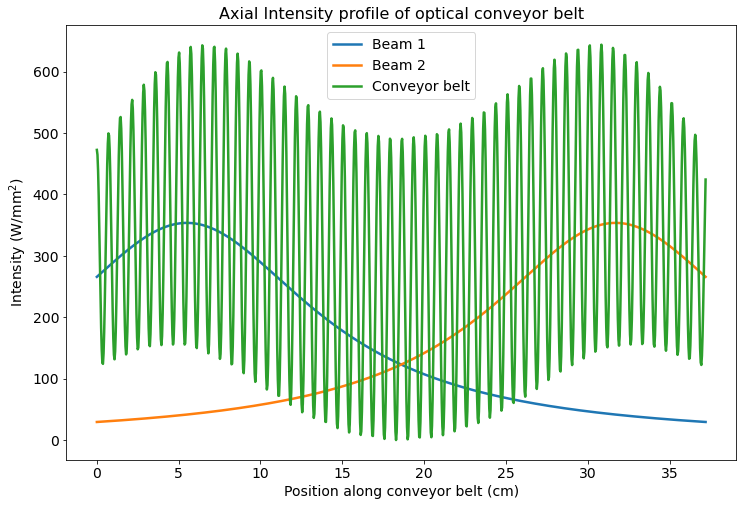

In [89]:
#plot the conveyor belt intensity profile

plt.figure(figsize=(12, 8))  # Set the figure size
#along the beam axis
y = 0
z = 0
x = np.linspace(0,L,1000)
intensity = conveyor_intensity(x,x0,y,z,w0,lam,P)/1e6
intensity1 = gaussian_beam_intensity(x,x0,y,z,w0,lam,P)/1e6
intensity2 = gaussian_beam_intensity(x,L-x0,y,z,w0,lam,P)/1e6
plt.plot(x*1e2,intensity1,label='Beam 1', linewidth=2.5)
plt.plot(x*1e2,intensity2,label='Beam 2', linewidth=2.5)
plt.plot(x*1e2,intensity,label='Conveyor belt', linewidth=2.5)
plt.xlabel('Position along conveyor belt (cm)', fontsize=14)
plt.ylabel('Intensity (W/mm$^2$)', fontsize=14)
plt.title('Axial Intensity profile of optical conveyor belt', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.show()

# Example of Optical Conveyor Belt Radial Intensity Profile Including Gravity

Gravity tilts the trapping potential because it's a linear mgz term.<br/>
The plot **replicates Fig. 2.8 in A. Matthies's thesis.**

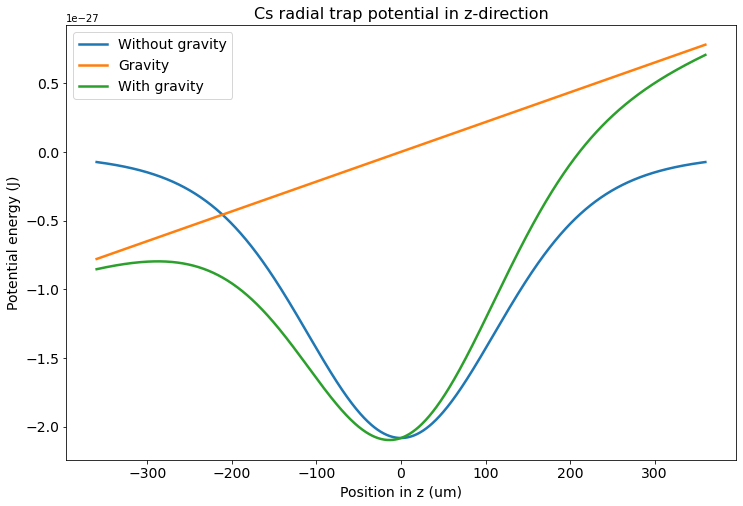

In [90]:
#plot radial depth including gravity (z-direction)

#first, let's plot an example of what the trapping potential looks like as a function of z, for some fixed axial position x along the belt
x = 10e-2 #10 cm along the belt
y = 0 

#potential well for Cs in the z-direction without gravity
def U_radial_Cs_without_grav(z,x,x0,w0,lam,P):
    return -alpha_Cs/(2*epsilon_0*c) * conveyor_intensity(x,x0,y,z,w0,lam,P)

#ignore cosine interference term
def U_radial_Cs_without_grav_no_cos(z,x,x0,w0,lam,P):
    return -alpha_Cs/(2*epsilon_0*c) * conveyor_intensity_no_cos(x,x0,y,z,w0,lam,P)

#potential well for Cs in z-direction including gravity
def U_radial_Cs_with_grav(z,x,x0,w0,lam,P):
    return U_radial_Cs_without_grav(z,x,x0,w0,lam,P) + m_Cs * g * z

def U_radial_Cs_with_grav_no_cos(z,x,x0,w0,lam,P):
    return U_radial_Cs_without_grav_no_cos(z,x,x0,w0,lam,P) + m_Cs * g * z

z = np.linspace(-2*w0,2*w0,1000)
plt.figure(figsize=(12, 8))
plt.plot(z*1e6,U_radial_Cs_without_grav(z,x,x0,w0,lam,P), label='Without gravity', linewidth=2.5)
plt.plot(z*1e6, m_Cs * g * z, label='Gravity', linewidth=2.5)
plt.plot(z*1e6,U_radial_Cs_with_grav(z,x,x0,w0,lam,P), label='With gravity', linewidth=2.5)
plt.xlabel('Position in z (um)', fontsize=14)
plt.ylabel('Potential energy (J)', fontsize=14)
plt.title('Cs radial trap potential in z-direction', fontsize=16)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

#extract difference between local max for z > 0 and local min
depth = (np.max(U_radial_Cs_with_grav(z,x,x0,w0,lam,P)[z<0]) - np.min(U_radial_Cs_with_grav(z,x,x0,w0,lam,P)))/k*1e6

# Cs Optical Transport Calculations

## Axial (x), Non-Gravity Radial (y), and Gravity Radial (z) Trap Depths along Transport Axis (x)

This **replicates Fig. 2b(iii) in the paper.**

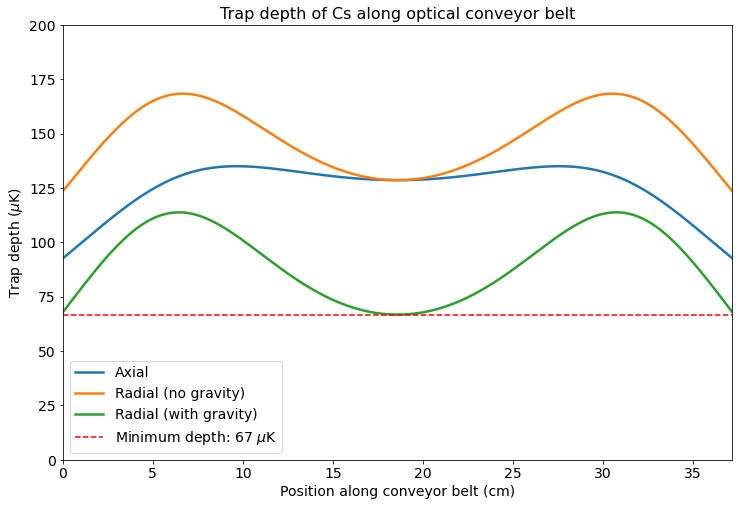

In [91]:
#now calculate the radial trap depth including gravity along the optical conveyor belt axis
#this reproduces Fig. 2b(iii) in the paper

x = np.linspace(0,L,1000)
y = 0
z = np.linspace(-2*w0,2*w0,1000)
depths = np.empty(len(x))

#no cos because we only consider trapping at the antinodes of the standing wave
for i in range(len(x)):
    depths[i] = (np.max(U_radial_Cs_with_grav_no_cos(z,x[i],x0,w0,lam,P)[z<0]) - np.min(U_radial_Cs_with_grav_no_cos(z,x[i],x0,w0,lam,P)))/k*1e6

#plot radial and axial trap depths

#in hindsight I could probably also do this with no cos since we only care about the antinodes?
def U_axial_potential_Cs(x,x0,y,z,w0,lam,P):
    return -(alpha_Cs/(2*epsilon_0*c))*conveyor_intensity(x,x0,y,z,w0,lam,P)

#axial trap depth of Cs in uK (x-direction)
def U_axial_Cs(x,x0,w0,lam,P):
    peak_intensity1 = I0(P,x,w0,x0,lam)
    peak_intensity2 = I0(P,x,w0,L-x0,lam)
    return (2*alpha_Cs*np.sqrt(peak_intensity1*peak_intensity2)/(epsilon_0*c)/k)*1e6

#radial trap depth of Cs in uK without gravity (y-direction)
def U_radial_Cs(x,x0,w0,lam,P):
    peak_intensity1 = I0(P,x,w0,x0,lam)
    peak_intensity2 = I0(P,x,w0,L-x0,lam)
    return (alpha_Cs/(2*epsilon_0*c)) * (peak_intensity1 + peak_intensity2 + 2*np.sqrt(peak_intensity1*peak_intensity2))/k*1e6

min_axial = np.min(U_axial_Cs(x,x0,w0,lam,P))
min_radial = np.min(U_radial_Cs(x,x0,w0,lam,P))
min_radial_grav = np.min(depths)
overall_min = min(min_axial, min_radial, min_radial_grav)

plt.figure(figsize=(12, 8))
plt.plot(x*1e2,U_axial_Cs(x,x0,w0,lam,P), label='Axial', linewidth=2.5)
plt.plot(x*1e2,U_radial_Cs(x,x0,w0,lam,P), label='Radial (no gravity)', linewidth=2.5)
plt.plot(x*1e2,depths, label='Radial (with gravity)', linewidth=2.5)
plt.axhline(y=overall_min, color='red', linestyle='--', label=f'Minimum depth: {round(overall_min)} $\mu$K')
plt.xlabel('Position along conveyor belt (cm)', fontsize=14)
plt.ylabel('Trap depth ($\mu$K)', fontsize=14)
plt.title('Trap depth of Cs along optical conveyor belt', fontsize=16)
plt.ylim(0, 200)
plt.xlim(0, L*1e2)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.show()

# Optimize for beam waist (w0) and focus (x0) positions for no magnetic levitation
## Compute minimum Cs trap depth (among axial and radial) along transport path.

This **replicates Fig. 2a in paper and Fig. 2.15 in thesis.**

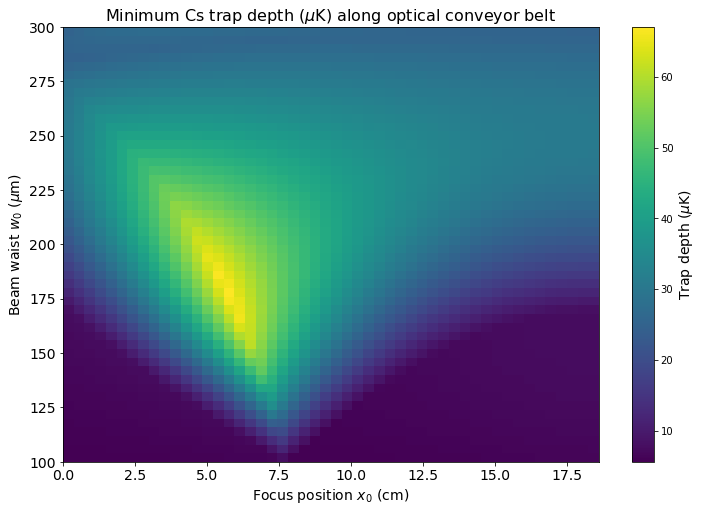

In [92]:
#for a range of beam waists and focus positions, compute the minimum trap depth (among radial and axial)
#along the optical conveyor belt path
#this reproduces Fig. 2a in the paper and Fig. 2.15 of the thesis.

x0s = np.linspace(0, 18.6e-2, 50) #in m
w0s = np.linspace(100e-6, 300e-6, 50) #in m
overall_mins = np.empty((len(x0s), len(w0s)))
L = 37.2e-2 #length of conveyor belt in m
lam = 1064e-9 #wavelength of trapping light in m
P = 18 #power of light in W

for i in range(len(x0s)):
    for j in range(len(w0s)):
        x = np.linspace(0,L,1000)
        y = 0
        z = np.linspace(-2*w0s[j],2*w0s[j],1000)
        depths = np.empty(len(x))

        #no cos because we only consider trapping at the antinodes of the standing wave
        for index in range(len(x)):
            depths[index] = (np.max(U_radial_Cs_with_grav_no_cos(z,x[index],x0s[i],w0s[j],lam,P)[z<0]) - np.min(U_radial_Cs_with_grav_no_cos(z,x[index],x0s[i],w0s[j],lam,P)))/k*1e6

        min_axial = np.min(U_axial_Cs(x,x0s[i],w0s[j],lam,P))
        min_radial = np.min(U_radial_Cs(x,x0s[i],w0s[j],lam,P))
        min_radial_grav = np.min(depths)
        overall_min = min(min_axial, min_radial, min_radial_grav)
        overall_mins[i][j] = overall_min
        #print(overall_mins[i][j], i, j, x0s[i], w0s[j])

overall_mins_final = np.transpose(overall_mins) #rows and cols in 2d matrix plot are flipped
plt.figure(figsize=(12, 8))
plt.imshow(overall_mins_final, extent=[0, 18.6, 100, 300], origin='lower', aspect='auto')
plt.colorbar().set_label('Trap depth ($\mu$K)', fontsize=14)
plt.xlabel('Focus position $x_0$ (cm)', fontsize=14)
plt.ylabel('Beam waist $w_0$ ($\mu$m)', fontsize=14)
plt.title('Minimum Cs trap depth ($\mu$K) along optical conveyor belt', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

# Account for Magnetic Levitation

## Define radial (Br) and axial (Bz) fields for current loop (cylindrical coordinates)

In [93]:
#account for magnetic levitation at beginning and end of conveyor belt
#magnetic levitation is achieved by using a B-field gradient to cancel the force of gravity at the beginning and end of the conveyor belt (in the MOT and science cell regions)
#first let's calculate some parameters related to the magnetic forces

#using Biot-Savart law and working in cylindrical coordinates, we compute Br and Bz (radial and axial components of B-field) for a current loop
#note here that r is radial in the coils, i.e. one of the directions is the transport axis

#r is radial distance from center of current loop. R is radius of current loop. 
#s is the separation between the two current loops. z is axial distance from center of current loop. I is current in the loop
def Br(r,R,s,z,I):
    prefactor = mu_0 * I / (2 * np.pi)
    z_tilde = z-s/2
    kappa = 4*R*r/((R+r)**2+(z_tilde)**2)
    K = ellipk(kappa)
    E = ellipe(kappa)
    field = prefactor * (z_tilde/(r*np.sqrt((R+r)**2 + z_tilde**2)))*((R**2+r**2+z_tilde**2)/((R-r)**2+z_tilde**2)*E - K)
    return field

def Bz(r,R,s,z,I):
    prefactor = mu_0 * I / (2 * np.pi)
    z_tilde = z-s/2
    kappa = 4*R*r/((R+r)**2+(z_tilde)**2)
    K = ellipk(kappa)
    E = ellipe(kappa)
    field = prefactor * (1/np.sqrt((R+r)**2 + z_tilde**2)) * ((R**2-r**2-z_tilde**2)/((R-r)**2+z_tilde**2)*E + K)
    return field

# Bias and Quadrupole Coil Parameters for MOT Chamber (MC) and Science Cell (SC)

In [94]:
#parameters for MOT chamber and science chamber coil radius, separation, and number of turns

RBias_MC = 6.6e-2 #radius of bias MOT chamber coil in m
RBias_SC = 5.156e-2 #radius of bias science chamber coil in m
RQuad_MC = 4.0e-2 #radius of quadrupole MOT chamber coil in m
RQuad_SC = 3.917e-2 #radius of quadrupole science chamber coil in m


sBias_MC = 6.83e-2 #separation of bias MOT chamber coils in m
sBias_SC = 5.88e-2 #separation of bias science chamber coils in m
sQuad_MC = 6.89e-2 #separation of quadrupole MOT chamber coils in m
sQuad_SC = 5.2e-2 #separation of quadrupole science chamber coils in m

NBias_MC = 8 #number of turns in bias MOT chamber coil
NBias_SC = 12 #number of turns in bias science chamber coil
NQuad_MC = 6 #number of turns in quadrupole MOT chamber coil
NQuad_SC = 6 #number of turns in quadrupole science chamber coil

# Compute Current in MC and SC Coils needed for Levitation and DC Bias

31 G/cm levitates both Rb and Cs in their energetically lowest Zeeman states (F=3, mF=3 for Cs and F=1, mF=1 for Rb).<br/>
22 G bias field pushes B-field zero below z = 0, which is needed for high-field seeking states.

We find we need **I_bias_MC = 20.6 A, I_bias_SC = 11.5 A, I_quad_MC = 101.9 A, I_quad_SC = 78.9 A.**

In [95]:
#compute the current used in the coils before computing B-field along transport axis. We need 22 G offset at MOT and SC chamber center. 31 G/cm gradient at same.
#this could probably be done in Mathematica if I solve the equations but I'm just going to be lazy and brute force it in Python

#first for the bias field. z = 0 and r = 0. Helmholtz configuration (current in same direction in both loops.)
IBias_MC = 20.6161 #current in A
BzBias_MC = (Bz(0,RBias_MC,sBias_MC,0,NBias_MC*IBias_MC) + Bz(0,RBias_MC,-sBias_MC,0,NBias_MC*IBias_MC))*1e4 #in Gauss
print("MOT chamber Bias field in Gauss:", BzBias_MC)

IBias_SC = 11.4746 #current in A
BzBias_SC = (Bz(0,RBias_SC,sBias_SC,0,NBias_SC*IBias_SC) + Bz(0,RBias_SC,-sBias_SC,0,NBias_SC*IBias_SC))*1e4 #in Gauss
print("Science chamber Bias field in Gauss:", BzBias_SC)

#next for the quadrupole field. z = 0 and r = 0.
IQuad_MC = 101.9379 #current in A
BzQuad_MC = (Bz(0e-2,RQuad_MC,sQuad_MC,0.001e-2,NQuad_MC*IQuad_MC) + Bz(0e-2,RQuad_MC,-sQuad_MC,0.001e-2,-NQuad_MC*IQuad_MC))*1e4 #in Gauss
BrQuad_MC = (Br(0.001e-2,RQuad_MC,sQuad_MC,0e-2,NQuad_MC*IQuad_MC) + Br(0.001e-2,RQuad_MC,-sQuad_MC,0e-2,-NQuad_MC*IQuad_MC))*1e4 #in Gauss
print("MOT chamber quadrupole field gradient (axial) in Gauss/cm:", BzQuad_MC/0.001)
print("MOT chamber quadrupole field gradient (radial) in Gauss/cm:", BrQuad_MC/0.001)

IQuad_SC = 78.9081 #current in A
BzQuad_SC = (Bz(0,RQuad_SC,sQuad_SC,0.001e-2,NQuad_SC*IQuad_SC) + Bz(0,RQuad_SC,-sQuad_SC,0.001e-2,-NQuad_SC*IQuad_SC))*1e4 #in Gauss
BrQuad_SC = (Br(0.001e-2,RQuad_SC,sQuad_SC,0e-2,NQuad_SC*IQuad_SC) + Br(0.001e-2,RQuad_SC,-sQuad_SC,0e-2,-NQuad_SC*IQuad_SC))*1e4 #in Gauss
print("Science chamber quadrupole field gradient (axial) in Gauss/cm:", BzQuad_SC/0.001)
print("Science chamber quadrupole field gradient (radial) in Gauss/cm:", BrQuad_SC/0.001)
print("As expected, radial gradient is -0.5*axial gradient to satisfy div B = 0 in free space.")

MOT chamber Bias field in Gauss: 22.000035557580357
Science chamber Bias field in Gauss: 22.000050858495307
MOT chamber quadrupole field gradient (axial) in Gauss/cm: 31.00000628625428
MOT chamber quadrupole field gradient (radial) in Gauss/cm: -15.500003197707434
Science chamber quadrupole field gradient (axial) in Gauss/cm: 31.00000943050997
Science chamber quadrupole field gradient (radial) in Gauss/cm: -15.500005661474775
As expected, radial gradient is -0.5*axial gradient to satisfy div B = 0 in free space.


# Compute |B| along transport axis (x, y=0, z=0)

We find |B| is always non-zero, providing a quantization axis for atoms throughout transport.<br/>
Gradients of |B| with respect to x, y, and z provide magnetic levitation/trapping (or anti-trapping) forces for atoms during transport.<br/>
This **replicates Fig. 2.10 in the thesis.**

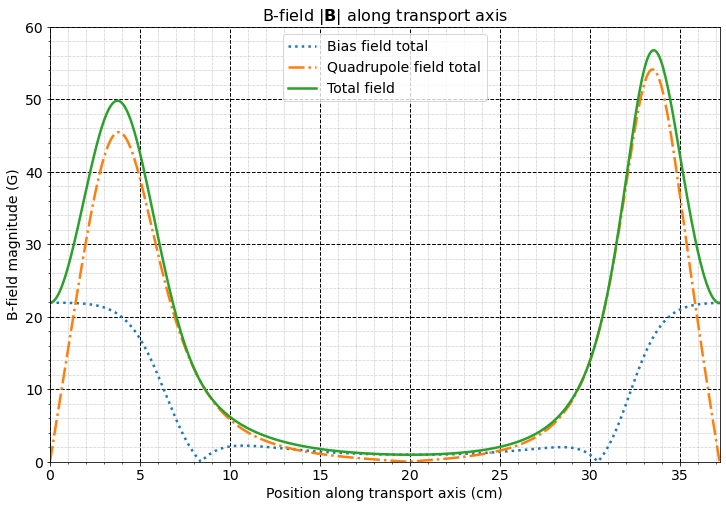

In [96]:
#compute magnitude of B-field along transport axis, replicating Fig. 2.10 in A. Matthies thesis

#in our common coordinate system, place MOT chamber at x,y,z = 0,0,0. Then science chamber is at x,y,z = 37.2e-2,0,0. Work in cylindrical coordinates. 
#On transport axis, only vary x (aka r) while y,z=0,0. 

L = 37.2e-2 #length of conveyor belt in m
x = np.linspace(0,L,1000)
BzsBias_MC = np.empty(len(x))
BrsBias_MC = np.empty(len(x))
BzsQuad_MC = np.empty(len(x))
BrsQuad_MC = np.empty(len(x))

BzsBias_SC = np.empty(len(x))
BrsBias_SC = np.empty(len(x))
BzsQuad_SC = np.empty(len(x))
BrsQuad_SC = np.empty(len(x))

for i in range(len(x)):
    if x[i] == 0 or x[i] == L:
        BrsBias_MC[i] = 0
        BrsQuad_MC[i] = 0
        BrsBias_SC[i] = 0
        BrsQuad_SC[i] = 0
        BzsBias_MC[i] = (Bz(x[i],RBias_MC,sBias_MC,0,NBias_MC*IBias_MC) + Bz(x[i],RBias_MC,-sBias_MC,0,NBias_MC*IBias_MC))*1e4 #in Gauss
        BzsQuad_MC[i] = (Bz(x[i],RQuad_MC,sQuad_MC,0,NQuad_MC*IQuad_MC) + Bz(x[i],RQuad_MC,-sQuad_MC,0,-NQuad_MC*IQuad_MC))*1e4 #in Gauss
        BzsBias_SC[i] = (Bz(L-x[i],RBias_SC,sBias_SC,0,NBias_SC*IBias_SC) + Bz(L-x[i],RBias_SC,-sBias_SC,0,NBias_SC*IBias_SC))*1e4 #in Gauss
        BzsQuad_SC[i] = (Bz(L-x[i],RQuad_SC,sQuad_SC,0,NQuad_SC*IQuad_SC) + Bz(L-x[i],RQuad_SC,-sQuad_SC,0,-NQuad_SC*IQuad_SC))*1e4 #in Gauss
        continue

    BzsBias_MC[i] = (Bz(x[i],RBias_MC,sBias_MC,0,NBias_MC*IBias_MC) + Bz(x[i],RBias_MC,-sBias_MC,0,NBias_MC*IBias_MC))*1e4 #in Gauss
    BrsBias_MC[i] = (Br(x[i],RBias_MC,sBias_MC,0,NBias_MC*IBias_MC) + Br(x[i],RBias_MC,-sBias_MC,0,NBias_MC*IBias_MC))*1e4 #in Gauss
    BzsQuad_MC[i] = (Bz(x[i],RQuad_MC,sQuad_MC,0,NQuad_MC*IQuad_MC) + Bz(x[i],RQuad_MC,-sQuad_MC,0,-NQuad_MC*IQuad_MC))*1e4 #in Gauss
    BrsQuad_MC[i] = (Br(x[i],RQuad_MC,sQuad_MC,0,NQuad_MC*IQuad_MC) + Br(x[i],RQuad_MC,-sQuad_MC,0,-NQuad_MC*IQuad_MC))*1e4 #in Gauss

    BzsBias_SC[i] = (Bz(L-x[i],RBias_SC,sBias_SC,0,NBias_SC*IBias_SC) + Bz(L-x[i],RBias_SC,-sBias_SC,0,NBias_SC*IBias_SC))*1e4 #in Gauss
    BrsBias_SC[i] = (-Br(L-x[i],RBias_SC,sBias_SC,0,NBias_SC*IBias_SC) - Br(L-x[i],RBias_SC,-sBias_SC,0,NBias_SC*IBias_SC))*1e4 #in Gauss
    BzsQuad_SC[i] = (Bz(L-x[i],RQuad_SC,sQuad_SC,0,NQuad_SC*IQuad_SC) + Bz(L-x[i],RQuad_SC,-sQuad_SC,0,-NQuad_SC*IQuad_SC))*1e4 #in Gauss
    BrsQuad_SC[i] = (-Br(L-x[i],RQuad_SC,sQuad_SC,0,NQuad_SC*IQuad_SC) - Br(L-x[i],RQuad_SC,-sQuad_SC,0,-NQuad_SC*IQuad_SC))*1e4 #in Gauss


BBias_MC = np.sqrt(BzsBias_MC**2 + BrsBias_MC**2)
BQuad_MC = np.sqrt(BzsQuad_MC**2 + BrsQuad_MC**2)
BBias_SC = np.sqrt(BzsBias_SC**2 + BrsBias_SC**2)
BQuad_SC = np.sqrt(BzsQuad_SC**2 + BrsQuad_SC**2)

BBias_Total = np.sqrt((BzsBias_MC + BzsBias_SC)**2 + (BrsBias_MC + BrsBias_SC)**2)
BQuad_Total = np.sqrt((BzsQuad_MC + BzsQuad_SC)**2 + (BrsQuad_MC + BrsQuad_SC)**2)
BTotal = np.sqrt((BzsBias_MC + BzsBias_SC + BzsQuad_MC + BzsQuad_SC)**2 + (BrsBias_MC + BrsBias_SC + BrsQuad_MC + BrsQuad_SC)**2)


plt.figure(figsize=(12, 8))
plt.plot(x*1e2, BBias_Total, label='Bias field total', ls=':', linewidth=2.5)
plt.plot(x*1e2, BQuad_Total, label='Quadrupole field total', ls='-.', linewidth=2.5)
plt.plot(x*1e2, BTotal, label='Total field', linewidth=2.5)
plt.xlabel('Position along transport axis (cm)', fontsize=14)
plt.ylabel('B-field magnitude (G)', fontsize=14)
plt.xlim(0, L*1e2)
plt.ylim(0, 60)
plt.title('B-field $|\mathbf{B}|$ along transport axis', fontsize=16)
plt.legend(fontsize=14)
plt.grid(linestyle = '--', which = 'major', linewidth = 1, color='black')
plt.grid(linestyle = ':', which = 'minor', linewidth = 0.5, color = 'gray')
plt.minorticks_on()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

# Compute magnetic levitation of Cs atoms along transport axis due to vertical (z) gradient in |B|

Vertical gradient d|B|/dz creates magnetic levitation (**maglev**) for the atoms. <br/>
Compute change in |B| from z=0 cm to z=0.01 cm along transport axis. Hold y=0. <br/>
Associated maglev force can cancel out trap tilting from gravity (shown as effective gravity).<br/>
This **replicates Fig. 3a of paper and Fig. 2.9 of thesis.**

Moreover, it turns out that **d|B|/dy is negligible for this geometry**, probably because of the cylindrical symmetry of the setup.<br/>
Calculations done in "Practice" show it **leads to accelerations of 0.1% g near the coils, and 0 in the middle of the transport path**. <br/>
So we don't need to worry about magnetic forces in the y-radial direction.<br/>
d|B|/dx is not as negligible (as can be seen from above plot), and leads to values up to 10 G/cm. <br/> 
However, because **axial traps are ~500 um across, d|B|/dx across the trap is negligible** and does not contribute to any meaningful acceleration.

Henceforth, we **ignore magnetic field gradient contribution to trap depth in x and y-directions.**

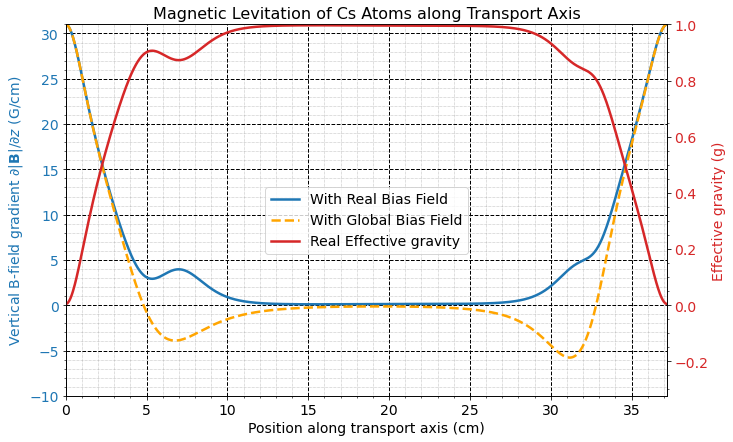

In [97]:
#compute the vertical component of B-field gradient along transport axis and effective gravitational acceleration experienced by the atoms.
#note that we care about gradient in |B| along z-axis, and want to see how this changes across the transport axis.
#so we will compute |B| at z = 0 and z = 0.001 cm, and then compute the gradient in |B| along z-axis. And then do this across the transport axis.
#This reproduces Fig. 3a of the paper and Fig. 2.9 of the thesis.

L = 37.2e-2 #length of conveyor belt in m
x = np.linspace(0,L,1000)

#point 1 is on-axis (z=0) and point 2 is off-axis (z=0.001 cm)
BzsBias_MC1 = np.empty(len(x))
BzsBias_MC2 = np.empty(len(x))
BzsQuad_MC1 = np.empty(len(x))
BzsQuad_MC2 = np.empty(len(x))
BrsBias_MC1 = np.empty(len(x))
BrsBias_MC2 = np.empty(len(x))
BrsQuad_MC1 = np.empty(len(x))
BrsQuad_MC2 = np.empty(len(x))

BzsBias_SC1 = np.empty(len(x))
BzsBias_SC2 = np.empty(len(x))
BzsQuad_SC1 = np.empty(len(x))
BzsQuad_SC2 = np.empty(len(x))
BrsBias_SC1 = np.empty(len(x))
BrsBias_SC2 = np.empty(len(x))
BrsQuad_SC1 = np.empty(len(x))
BrsQuad_SC2 = np.empty(len(x))

for i in range(len(x)):
    z1 = 0e-2
    z2 = 0.01e-2
    if x[i] == 0 or x[i] == L:
        BrsBias_MC1[i] = 0
        BrsQuad_MC1[i] = 0
        BrsBias_SC1[i] = 0
        BrsQuad_SC1[i] = 0
        BrsBias_MC2[i] = 0
        BrsQuad_MC2[i] = 0
        BrsBias_SC2[i] = 0
        BrsQuad_SC2[i] = 0
        BzsBias_MC1[i] = (Bz(x[i],RBias_MC,sBias_MC,z1,NBias_MC*IBias_MC) + Bz(x[i],RBias_MC,-sBias_MC,z1,NBias_MC*IBias_MC))*1e4 #in Gauss
        BzsQuad_MC1[i] = (Bz(x[i],RQuad_MC,sQuad_MC,z1,NQuad_MC*IQuad_MC) + Bz(x[i],RQuad_MC,-sQuad_MC,z1,-NQuad_MC*IQuad_MC))*1e4 #in Gauss
        BzsBias_SC1[i] = (Bz(L-x[i],RBias_SC,sBias_SC,z1,NBias_SC*IBias_SC) + Bz(L-x[i],RBias_SC,-sBias_SC,z1,NBias_SC*IBias_SC))*1e4 #in Gauss
        BzsQuad_SC1[i] = (Bz(L-x[i],RQuad_SC,sQuad_SC,z1,NQuad_SC*IQuad_SC) + Bz(L-x[i],RQuad_SC,-sQuad_SC,z1,-NQuad_SC*IQuad_SC))*1e4 #in Gauss
        BzsBias_MC2[i] = (Bz(x[i],RBias_MC,sBias_MC,z2,NBias_MC*IBias_MC) + Bz(x[i],RBias_MC,-sBias_MC,z2,NBias_MC*IBias_MC))*1e4 #in Gauss
        BzsQuad_MC2[i] = (Bz(x[i],RQuad_MC,sQuad_MC,z2,NQuad_MC*IQuad_MC) + Bz(x[i],RQuad_MC,-sQuad_MC,z2,-NQuad_MC*IQuad_MC))*1e4 #in Gauss
        BzsBias_SC2[i] = (Bz(L-x[i],RBias_SC,sBias_SC,z2,NBias_SC*IBias_SC) + Bz(L-x[i],RBias_SC,-sBias_SC,z2,NBias_SC*IBias_SC))*1e4 #in Gauss
        BzsQuad_SC2[i] = (Bz(L-x[i],RQuad_SC,sQuad_SC,z2,NQuad_SC*IQuad_SC) + Bz(L-x[i],RQuad_SC,-sQuad_SC,z2,-NQuad_SC*IQuad_SC))*1e4 #in Gauss
        continue

    BzsBias_MC1[i] = (Bz(x[i],RBias_MC,sBias_MC,z1,NBias_MC*IBias_MC) + Bz(x[i],RBias_MC,-sBias_MC,z1,NBias_MC*IBias_MC))*1e4 #in Gauss
    BzsQuad_MC1[i] = (Bz(x[i],RQuad_MC,sQuad_MC,z1,NQuad_MC*IQuad_MC) + Bz(x[i],RQuad_MC,-sQuad_MC,z1,-NQuad_MC*IQuad_MC))*1e4 #in Gauss
    BzsBias_SC1[i] = (Bz(L-x[i],RBias_SC,sBias_SC,z1,NBias_SC*IBias_SC) + Bz(L-x[i],RBias_SC,-sBias_SC,z1,NBias_SC*IBias_SC))*1e4 #in Gauss
    BzsQuad_SC1[i] = (Bz(L-x[i],RQuad_SC,sQuad_SC,z1,NQuad_SC*IQuad_SC) + Bz(L-x[i],RQuad_SC,-sQuad_SC,z1,-NQuad_SC*IQuad_SC))*1e4 #in Gauss
    BrsBias_MC1[i] = (Br(x[i],RBias_MC,sBias_MC,z1,NBias_MC*IBias_MC) + Br(x[i],RBias_MC,-sBias_MC,z1,NBias_MC*IBias_MC))*1e4 #in Gauss
    BrsQuad_MC1[i] = (Br(x[i],RQuad_MC,sQuad_MC,z1,NQuad_MC*IQuad_MC) + Br(x[i],RQuad_MC,-sQuad_MC,z1,-NQuad_MC*IQuad_MC))*1e4 #in Gauss
    BrsBias_SC1[i] = (-Br(L-x[i],RBias_SC,sBias_SC,z1,NBias_SC*IBias_SC) - Br(L-x[i],RBias_SC,-sBias_SC,z1,NBias_SC*IBias_SC))*1e4 #in Gauss
    BrsQuad_SC1[i] = (-Br(L-x[i],RQuad_SC,sQuad_SC,z1,NQuad_SC*IQuad_SC) - Br(L-x[i],RQuad_SC,-sQuad_SC,z1,-NQuad_SC*IQuad_SC))*1e4 #in Gauss
    BzsBias_MC2[i] = (Bz(x[i],RBias_MC,sBias_MC,z2,NBias_MC*IBias_MC) + Bz(x[i],RBias_MC,-sBias_MC,z2,NBias_MC*IBias_MC))*1e4 #in Gauss
    BzsQuad_MC2[i] = (Bz(x[i],RQuad_MC,sQuad_MC,z2,NQuad_MC*IQuad_MC) + Bz(x[i],RQuad_MC,-sQuad_MC,z2,-NQuad_MC*IQuad_MC))*1e4 #in Gauss
    BzsBias_SC2[i] = (Bz(L-x[i],RBias_SC,sBias_SC,z2,NBias_SC*IBias_SC) + Bz(L-x[i],RBias_SC,-sBias_SC,z2,NBias_SC*IBias_SC))*1e4 #in Gauss
    BzsQuad_SC2[i] = (Bz(L-x[i],RQuad_SC,sQuad_SC,z2,NQuad_SC*IQuad_SC) + Bz(L-x[i],RQuad_SC,-sQuad_SC,z2,-NQuad_SC*IQuad_SC))*1e4 #in Gauss
    BrsBias_MC2[i] = (Br(x[i],RBias_MC,sBias_MC,z2,NBias_MC*IBias_MC) + Br(x[i],RBias_MC,-sBias_MC,z2,NBias_MC*IBias_MC))*1e4 #in Gauss
    BrsQuad_MC2[i] = (Br(x[i],RQuad_MC,sQuad_MC,z2,NQuad_MC*IQuad_MC) + Br(x[i],RQuad_MC,-sQuad_MC,z2,-NQuad_MC*IQuad_MC))*1e4 #in Gauss
    BrsBias_SC2[i] = (-Br(L-x[i],RBias_SC,sBias_SC,z2,NBias_SC*IBias_SC) - Br(L-x[i],RBias_SC,-sBias_SC,z2,NBias_SC*IBias_SC))*1e4 #in Gauss
    BrsQuad_SC2[i] = (-Br(L-x[i],RQuad_SC,sQuad_SC,z2,NQuad_SC*IQuad_SC) - Br(L-x[i],RQuad_SC,-sQuad_SC,z2,-NQuad_SC*IQuad_SC))*1e4 #in Gauss


BTotal1 = np.sqrt((BzsBias_MC1 + BzsBias_SC1 + BzsQuad_MC1 + BzsQuad_SC1)**2 + (BrsBias_MC1 + BrsBias_SC1 + BrsQuad_MC1 + BrsQuad_SC1)**2)
BTotal2 = np.sqrt((BzsBias_MC2 + BzsBias_SC2 + BzsQuad_MC2 + BzsQuad_SC2)**2 + (BrsBias_MC2 + BrsBias_SC2 + BrsQuad_MC2 + BrsQuad_SC2)**2)
BGradTotal_z = (BTotal2 - BTotal1)/((z2-z1)/(1e-2)) #in G/cm

#modified case where there is just a global offset bias field 
BGlobalOffset = 22 #in Gauss
BTotal1Mod = np.sqrt((BGlobalOffset + BzsQuad_MC1 + BzsQuad_SC1)**2 + (BrsQuad_MC1 + BrsQuad_SC1)**2)
BTotal2Mod = np.sqrt((BGlobalOffset + BzsQuad_MC2 + BzsQuad_SC2)**2 + (BrsQuad_MC2 + BrsQuad_SC2)**2)
BGradTotal_zMod = (BTotal2Mod - BTotal1Mod)/((z2-z1)/(1e-2)) #in G/cm

#now compute the effective gravity experienced by Cs atoms along the transport axis

#first compute the magnetic force on Cs atoms due to the B-field gradient
#Cs atoms are in mF = 3. gF = 0.25. 

mF = 3
gF = 0.25
mu_B = physical_constants['Bohr magneton'][0] #Bohr magneton in J/T
BGradTotal_z_SI = BGradTotal_z * 1e-2 #convert to T/m

a_eff = (m_Cs*g - mF*gF*mu_B*BGradTotal_z_SI)/m_Cs #effective acceleration in m/s^2
g_eff = a_eff/g #effective gravity in units of g

fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('Position along transport axis (cm)', fontsize=14)
ax1.set_ylabel('Vertical B-field gradient $\partial |\mathbf{B}|/\partial z$ (G/cm)', color=color, fontsize=14)
ax1.plot(x*1e2, BGradTotal_z, color=color, linewidth=2.5, label='With Real Bias Field')
ax1.plot(x*1e2, BGradTotal_zMod, color='orange', linewidth=2.5, linestyle='--', label='With Global Bias Field')
ax1.tick_params(axis='y', labelcolor=color, labelsize=14)
ax1.tick_params(axis='x', labelsize=14)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('Effective gravity (g)', color=color, fontsize=14)  # we already handled the x-label with ax1
ax2.plot(x*1e2, g_eff, color=color, linewidth=2.5, label='Real Effective gravity')
ax2.tick_params(axis='y', labelcolor=color, labelsize=14)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
ax1.set_xlim(0, L*1e2)
ax1.set_ylim(-10, 31)
ax2.set_ylim(-10/31, 1.0)
ax1.grid(which='major', linestyle='--', linewidth=1, color='black')
ax1.grid(which='minor', linestyle=':', linewidth=0.5, color='gray')
ax1.minorticks_on()
ax2.minorticks_on()
fig.legend(loc='center', fontsize=14)
plt.title('Magnetic Levitation of Cs Atoms along Transport Axis', fontsize=16)
plt.show()

# Recompute Cs vertical radial (z) trap depth, now accounting for magnetic levitation

This **reproduces Fig. 3b of paper and Fig. 2.9(iii) in thesis.**

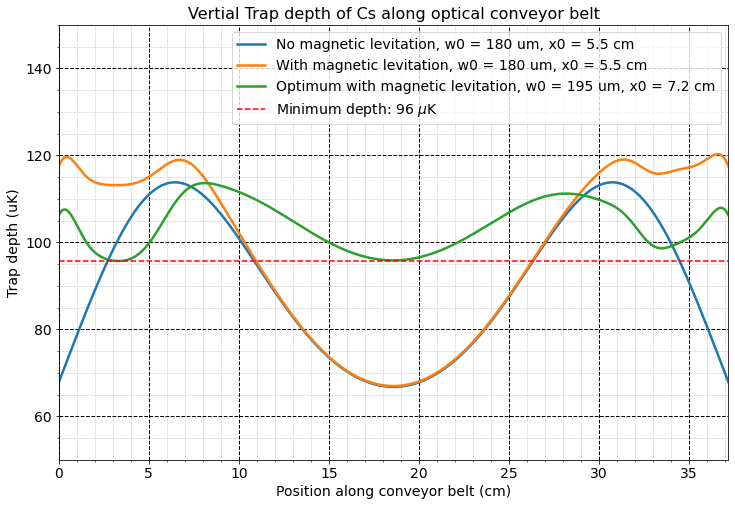

In [98]:
#recompute the vertical trap depth for Cs accounting for magnetic levitation (assume the horizontal trap depth is unaffected). 
#This reproduces Fig. 3b of the paper.

#first, reproduce plot for no magnetic levitation. The optimum parameters are x0 = 5.5 cm and w0 = 180 um.
x01 = 5.5e-2
w01 = 180e-6
x = np.linspace(0,L,1000)
y = 0
z1 = np.linspace(-2*w01,2*w01,1000)
depths = np.empty(len(x))
depths_with_mag = np.empty(len(x))
optimal_depths_with_mag = np.empty(len(x))

x02 = 7.2e-2
w02 = 195e-6
z2 = np.linspace(-2*w02,2*w02,1000)

def U_radial_Cs_with_grav_and_mag_no_cos(z,x,x0,w0,lam,P,a_eff_x):
    return U_radial_Cs_without_grav_no_cos(z,x,x0,w0,lam,P) + m_Cs * a_eff_x * z

#no cos because we only consider trapping at the antinodes of the standing wave
#trap depth in uK
for i in range(len(x)):
    depths[i] = (np.max(U_radial_Cs_with_grav_no_cos(z1,x[i],x01,w01,lam,P)[z<0]) - np.min(U_radial_Cs_with_grav_no_cos(z1,x[i],x01,w01,lam,P)))/k*1e6
    depths_with_mag[i] = (np.max(U_radial_Cs_with_grav_and_mag_no_cos(z1,x[i],x01,w01,lam,P,a_eff[i])[z<0]) - np.min(U_radial_Cs_with_grav_and_mag_no_cos(z1,x[i],x01,w01,lam,P,a_eff[i])))/k*1e6
    optimal_depths_with_mag[i] = (np.max(U_radial_Cs_with_grav_and_mag_no_cos(z2,x[i],x02,w02,lam,P,a_eff[i])[z<0]) - np.min(U_radial_Cs_with_grav_and_mag_no_cos(z2,x[i],x02,w02,lam,P,a_eff[i])))/k*1e6

#plot radial and axial trap depths
min_radial_grav = np.min(optimal_depths_with_mag)

plt.figure(figsize=(12, 8))
plt.plot(x*1e2, depths, label='No magnetic levitation, w0 = 180 um, x0 = 5.5 cm', linewidth=2.5)
plt.plot(x*1e2, depths_with_mag, label='With magnetic levitation, w0 = 180 um, x0 = 5.5 cm', linewidth=2.5)
plt.plot(x*1e2, optimal_depths_with_mag, label='Optimum with magnetic levitation, w0 = 195 um, x0 = 7.2 cm', linewidth=2.5)
plt.axhline(y=min_radial_grav, color='red', linestyle='--', label=f'Minimum depth: {round(min_radial_grav)} $\mu$K')
plt.xlabel('Position along conveyor belt (cm)', fontsize=14)
plt.ylabel('Trap depth (uK)', fontsize=14)
plt.title('Vertial Trap depth of Cs along optical conveyor belt', fontsize=16)
plt.ylim(50, 150)
plt.xlim(0, L*1e2)
plt.legend(fontsize=14)
plt.grid(linestyle = '--', which = 'major', linewidth = 1, color='black')
plt.grid(linestyle = ':', which = 'minor', linewidth = 0.5, color = 'gray')
plt.minorticks_on()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

# Optimize for beam waist (w0) and focus (x0) positions INCLUDING magnetic levitation.
## Compute minimum Cs trap depth (among axial and radial) along transport path.

This **replicates Fig. 2.17 in thesis.**

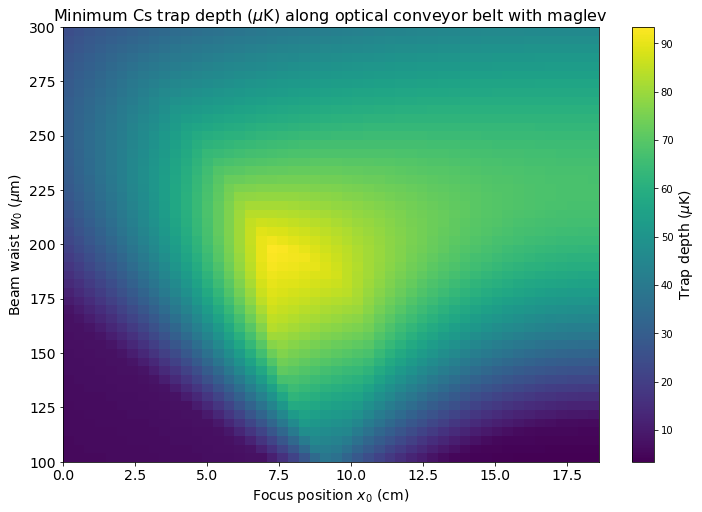

In [99]:
#for a range of beam waists and focus positions, re-compute the minimum trap depth (among radial and axial) - NOW ACCOUNTING FOR MAGNETIC LEVITATION
#along the optical conveyor belt path
#this reproduces Fig. 2.17 in A. Matthies thesis

x0s = np.linspace(0, 18.6e-2, 50) #in m
w0s = np.linspace(100e-6, 300e-6, 50) #in m
overall_mins = np.empty((len(x0s), len(w0s)))
L = 37.2e-2 #length of conveyor belt in m
lam = 1064e-9 #wavelength of trapping light in m
P = 18 #power of light in W

for i in range(len(x0s)):
    for j in range(len(w0s)):
        x = np.linspace(0,L,1000)
        y = 0
        z = np.linspace(-2*w0s[j],2*w0s[j],1000)
        depths_with_maglev = np.empty(len(x))

        #no cos because we only consider trapping at the antinodes of the standing wave
        for index in range(len(x)):
            depths_with_maglev[index] = (np.max(U_radial_Cs_with_grav_and_mag_no_cos(z1,x[index],x0s[i],w0s[j],lam,P,a_eff[index])[z<0]) - np.min(U_radial_Cs_with_grav_and_mag_no_cos(z1,x[index],x0s[i],w0s[j],lam,P,a_eff[index])))/k*1e6

        min_axial = np.min(U_axial_Cs(x,x0s[i],w0s[j],lam,P))
        min_radial = np.min(U_radial_Cs(x,x0s[i],w0s[j],lam,P))
        min_radial_maglev = np.min(depths_with_maglev)
        overall_min = min(min_axial, min_radial, min_radial_maglev)
        overall_mins[i][j] = overall_min
        #print(overall_mins[i][j], i, j, x0s[i], w0s[j])

overall_mins_final = np.transpose(overall_mins) #rows and cols in 2d matrix plot are flipped
plt.figure(figsize=(12, 8))
plt.imshow(overall_mins_final, extent=[0, 18.6, 100, 300], origin='lower', aspect='auto')
plt.colorbar().set_label('Trap depth ($\mu$K)', fontsize=14)
plt.xlabel('Focus position $x_0$ (cm)', fontsize=14)
plt.ylabel('Beam waist $w_0$ ($\mu$m)', fontsize=14)
plt.title('Minimum Cs trap depth ($\mu$K) along optical conveyor belt with maglev', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

# Compute axial and radial trap frequencies for Cs in presence of gravity and maglev

Note that because the potential is only quadratic near the bottom and the atoms are mainly sloshing around at the bottom of the potential well, then when we approximate the Gaussian as quadratic, we can ignore the reduced trap depth by gravity and partial compensation by magnetic field gradient.

In other words, radial trap frequency is same for y and z-direction. 

This **reproduces Fig. 4a (axial) and Fig. 4b (radial) of paper, and Fig. 2.22 of thesis.**

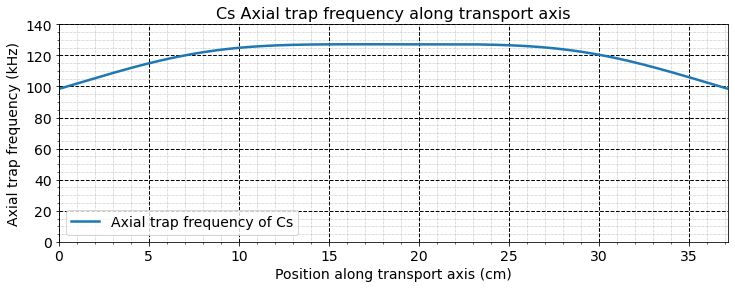

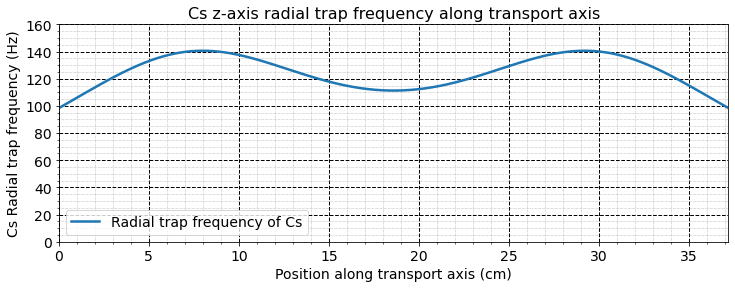

In [100]:
#now, set the optimum focus position and beam waist to the maglev case. We shall compute the trap frequencies in axial and radial directions.
#this reproduces Fig. 4a of the paper and Fig. 2.22 of thesis.

x0mag = 7.2e-2
w0mag = 195e-6

#for a chosen point on the transport axis, plot the axial trap potential (x), radial (y) trap potential, and radial (z, with grav and maglev) trap potential

#axial first
x = 0.25*lam
y = 0
z = 0

xs = np.arange(x, L, 1e3*lam)
axial_freqs = np.empty(len(xs))

#in hindsight I could probably also do this with no cos since we only care about the antinodes?
def U_axial_potential_Cs(x,x0,y,z,w0,lam,P):
    return -(alpha_Cs/(2*epsilon_0*c))*conveyor_intensity(x,x0,y,z,w0,lam,P)

#fit a parabola to the axial potential
def parabola(x, omega, b, c):
    return 0.5*m_Cs*(omega**2)*(x-b)**2 + c

for i in range(len(xs)):
    x_vals = np.linspace(xs[i]+0.18*lam, xs[i]+0.32*lam, 50)
    popt, pcov = curve_fit(parabola, x_vals, U_axial_potential_Cs(x_vals,x0mag,y,z,w0mag,lam,P), p0=[2*np.pi*100e3, xs[i]+0.25*lam, -2e-27])
    axial_freqs[i] = np.abs(popt[0])/(2*np.pi)/1e3

#plt.plot(x_vals, U_axial_potential_Cs(x_vals,x0mag,y,z,w0mag,lam,P), 'o', label='Axial')
#plt.plot(x_vals, parabola(x_vals, *popt), label='Fit')
#plt.legend()
#plt.show()
#print("Axial trap frequency (f) in kHz:", popt[0]/(2*np.pi)/1e3) 

plt.figure(figsize=(12, 4))
plt.plot(xs*1e2, axial_freqs, label='Axial trap frequency of Cs', linewidth=2.5)
plt.xlim(0, L*1e2)
plt.ylim(0, 140)
plt.xlabel('Position along transport axis (cm)', fontsize=14)
plt.ylabel('Axial trap frequency (kHz)', fontsize=14)
plt.title('Cs Axial trap frequency along transport axis', fontsize=16)
plt.grid(linestyle = '--', which = 'major', linewidth = 1, color='black')
plt.grid(linestyle = ':', which = 'minor', linewidth = 0.5, color = 'gray')
plt.minorticks_on()
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

#finally, let's compute the case for the radial trap frequency along the z-axis, with magnetic levitation and gravity
#this reproduces Fig. 4b of the paper and Fig. 2.22 of thesis.

xs = np.linspace(0, L, 1000)
y = 0
zradial_freqs = np.empty(len(xs))

def U_zradial_potential_Cs(x,x0,y,z,w0,lam,P, a_eff_x):
    return -(alpha_Cs/(2*epsilon_0*c))*conveyor_intensity_no_cos(x,x0,y,z,w0,lam,P) + m_Cs * a_eff_x * z

"""
#practice plot of potential in z-direction at x = 5.4e-2 m
xtry = 5.4e-2
zs = np.linspace(-0.25*w0mag, 0.25*w0mag, 50)
popt, pcov = curve_fit(parabola, zs, U_zradial_potential_Cs(xtry,x0mag,y,zs,w0mag,lam,P,a_eff[int(xtry/L*1000)]), p0=[2*np.pi*100, 0.001*w0mag, -2e-27])
plt.plot(zs*1e6, U_zradial_potential_Cs(xtry,x0mag,y,zs,w0mag,lam,P,a_eff[int(xtry/L*1000)]), 'o')
plt.plot(zs*1e6, parabola(zs, *popt))
plt.show()

print("z-radial trap frequency (f) in Hz:", popt[0]/(2*np.pi))
"""

for i in range(len(xs)):
    z_vals = np.linspace(-0.25*w0mag, 0.25*w0mag, 50)
    popt, pcov = curve_fit(parabola, z_vals, U_zradial_potential_Cs(xs[i],x0mag,y,z_vals,w0mag,lam,P,a_eff[i]), p0=[2*np.pi*100, 0.001*w0mag, -2e-27])
    zradial_freqs[i] = np.abs(popt[0])/(2*np.pi)

plt.figure(figsize=(12, 4))
plt.plot(xs*1e2, zradial_freqs, label='Radial trap frequency of Cs', linewidth=2.5)
plt.xlim(0, L*1e2)
plt.ylim(0, 160)
plt.xlabel('Position along transport axis (cm)', fontsize=14)
plt.ylabel('Cs Radial trap frequency (Hz)', fontsize=14)
plt.title('Cs z-axis radial trap frequency along transport axis', fontsize=16)
plt.grid(linestyle = '--', which = 'major', linewidth = 1, color='black')
plt.grid(linestyle = ':', which = 'minor', linewidth = 0.5, color = 'gray')
plt.minorticks_on()
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

#basically the radial frequencies are the same because near the potential minimum, the potential looks the same. 
#The trap depth is only lowered in the z-direction far away from maglev when the z-displacement is comparable to the waist size.

# Rb Optical Transport Calculations

## Replicate what was done above for Cs, but here for Rb atoms.

## First, compute axial (x), radial non-gravity (y), and radial gravity (z) trap depths along transport axis.

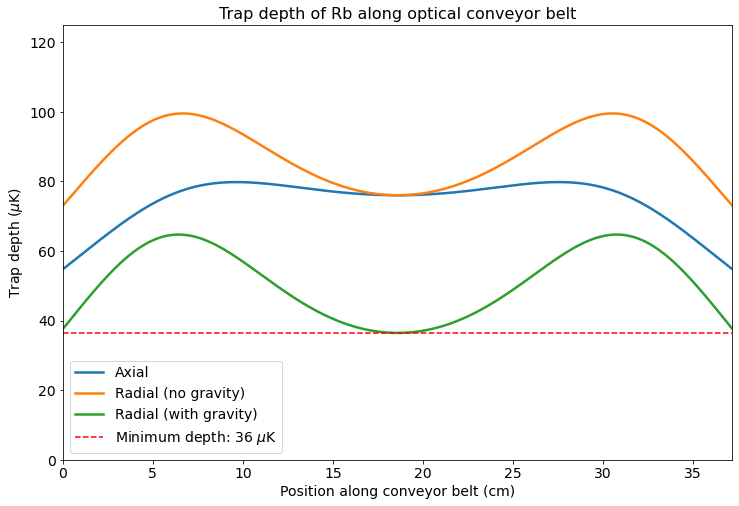

In [101]:
x = np.linspace(0,L,1000)
y = 0
z = np.linspace(-2*w0,2*w0,1000)
depths = np.empty(len(x))

#potential well for Rb in the z-direction without gravity
def U_radial_Rb_without_grav(z,x,x0,w0,lam,P):
    return -alpha_Rb/(2*epsilon_0*c) * conveyor_intensity(x,x0,y,z,w0,lam,P)

#ignore cosine interference term
def U_radial_Rb_without_grav_no_cos(z,x,x0,w0,lam,P):
    return -alpha_Rb/(2*epsilon_0*c) * conveyor_intensity_no_cos(x,x0,y,z,w0,lam,P)

#potential well for Rb in z-direction including gravity
def U_radial_Rb_with_grav(z,x,x0,w0,lam,P):
    return U_radial_Rb_without_grav(z,x,x0,w0,lam,P) + m_Rb * g * z

def U_radial_Rb_with_grav_no_cos(z,x,x0,w0,lam,P):
    return U_radial_Rb_without_grav_no_cos(z,x,x0,w0,lam,P) + m_Rb * g * z

#no cos because we only consider trapping at the antinodes of the standing wave
for i in range(len(x)):
    depths[i] = (np.max(U_radial_Rb_with_grav_no_cos(z,x[i],x0,w0,lam,P)[z<0]) - np.min(U_radial_Rb_with_grav_no_cos(z,x[i],x0,w0,lam,P)))/k*1e6

#plot radial and axial trap depths

#in hindsight I could probably also do this with no cos since we only care about the antinodes?
def U_axial_potential_Rb(x,x0,y,z,w0,lam,P):
    return -(alpha_Rb/(2*epsilon_0*c))*conveyor_intensity(x,x0,y,z,w0,lam,P)

#axial trap depth of Rb in uK (x-direction)
def U_axial_Rb(x,x0,w0,lam,P):
    peak_intensity1 = I0(P,x,w0,x0,lam)
    peak_intensity2 = I0(P,x,w0,L-x0,lam)
    return (2*alpha_Rb*np.sqrt(peak_intensity1*peak_intensity2)/(epsilon_0*c)/k)*1e6

#radial trap depth of Rb in uK without gravity (y-direction)
def U_radial_Rb(x,x0,w0,lam,P):
    peak_intensity1 = I0(P,x,w0,x0,lam)
    peak_intensity2 = I0(P,x,w0,L-x0,lam)
    return (alpha_Rb/(2*epsilon_0*c)) * (peak_intensity1 + peak_intensity2 + 2*np.sqrt(peak_intensity1*peak_intensity2))/k*1e6

min_axial = np.min(U_axial_Rb(x,x0,w0,lam,P))
min_radial = np.min(U_radial_Rb(x,x0,w0,lam,P))
min_radial_grav = np.min(depths)
overall_min = min(min_axial, min_radial, min_radial_grav)

plt.figure(figsize=(12, 8))
plt.plot(x*1e2,U_axial_Rb(x,x0,w0,lam,P), label='Axial', linewidth=2.5)
plt.plot(x*1e2,U_radial_Rb(x,x0,w0,lam,P), label='Radial (no gravity)', linewidth=2.5)
plt.plot(x*1e2,depths, label='Radial (with gravity)', linewidth=2.5)
plt.axhline(y=overall_min, color='red', linestyle='--', label=f'Minimum depth: {round(overall_min)} $\mu$K')
plt.xlabel('Position along conveyor belt (cm)', fontsize=14)
plt.ylabel('Trap depth ($\mu$K)', fontsize=14)
plt.title('Trap depth of Rb along optical conveyor belt', fontsize=16)
plt.ylim(0, 125)
plt.xlim(0, L*1e2)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.show()

# Optimize for beam waist (w0) and focus (x0) positions for no magnetic levitation
## Compute minimum Rb trap depth (among axial and radial) along transport path.

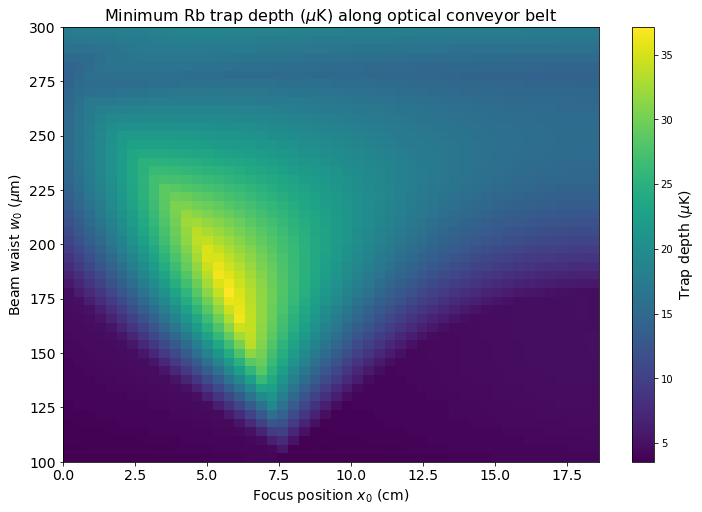

In [102]:
#for a range of beam waists and focus positions, compute the minimum trap depth (among radial and axial)
#along the optical conveyor belt path

x0s = np.linspace(0, 18.6e-2, 50) #in m
w0s = np.linspace(100e-6, 300e-6, 50) #in m
overall_mins = np.empty((len(x0s), len(w0s)))
L = 37.2e-2 #length of conveyor belt in m
lam = 1064e-9 #wavelength of trapping light in m
P = 18 #power of light in W

for i in range(len(x0s)):
    for j in range(len(w0s)):
        x = np.linspace(0,L,1000)
        y = 0
        z = np.linspace(-2*w0s[j],2*w0s[j],1000)
        depths = np.empty(len(x))

        #no cos because we only consider trapping at the antinodes of the standing wave
        for index in range(len(x)):
            depths[index] = (np.max(U_radial_Rb_with_grav_no_cos(z,x[index],x0s[i],w0s[j],lam,P)[z<0]) - np.min(U_radial_Rb_with_grav_no_cos(z,x[index],x0s[i],w0s[j],lam,P)))/k*1e6

        min_axial = np.min(U_axial_Rb(x,x0s[i],w0s[j],lam,P))
        min_radial = np.min(U_radial_Rb(x,x0s[i],w0s[j],lam,P))
        min_radial_grav = np.min(depths)
        overall_min = min(min_axial, min_radial, min_radial_grav)
        overall_mins[i][j] = overall_min
        #print(overall_mins[i][j], i, j, x0s[i], w0s[j])

overall_mins_final = np.transpose(overall_mins) #rows and cols in 2d matrix plot are flipped
plt.figure(figsize=(12, 8))
plt.imshow(overall_mins_final, extent=[0, 18.6, 100, 300], origin='lower', aspect='auto')
plt.colorbar().set_label('Trap depth ($\mu$K)', fontsize=14)
plt.xlabel('Focus position $x_0$ (cm)', fontsize=14)
plt.ylabel('Beam waist $w_0$ ($\mu$m)', fontsize=14)
plt.title('Minimum Rb trap depth ($\mu$K) along optical conveyor belt', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

# Compute magnetic levitation of Rb atoms along transport axis due to vertical (z) gradient in |B|

Vertical gradient d|B|/dz creates magnetic levitation (**maglev**) for the atoms. <br/>
Compute change in |B| from z=0 cm to z=0.01 cm along transport axis. Hold y=0. <br/>
Associated maglev force can cancel out trap tilting from gravity (shown as effective gravity).

Note that the result for Rb is remarkably close to Cs bc the ratio gF*mF/m is nearly identical for Rb and Cs.

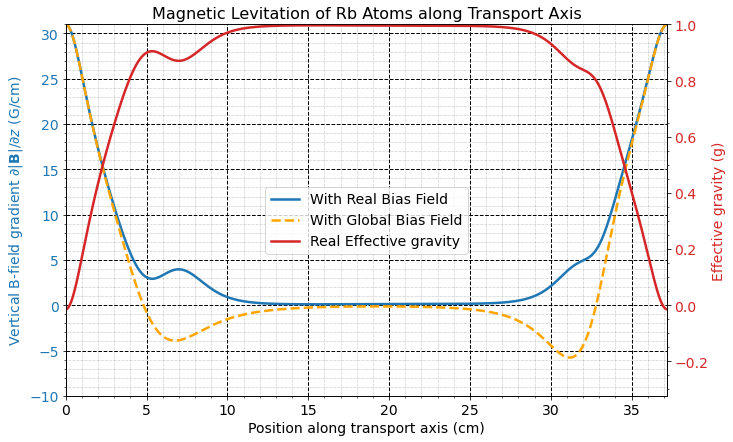

In [103]:
#compute the vertical component of B-field gradient along transport axis and effective gravitational acceleration experienced by the atoms.
#note that we care about gradient in |B| along z-axis, and want to see how this changes across the transport axis.
#so we will compute |B| at z = 0 and z = 0.001 cm, and then compute the gradient in |B| along z-axis. And then do this across the transport axis.

L = 37.2e-2 #length of conveyor belt in m
x = np.linspace(0,L,1000)

#point 1 is on-axis (z=0) and point 2 is off-axis (z=0.001 cm)
BzsBias_MC1 = np.empty(len(x))
BzsBias_MC2 = np.empty(len(x))
BzsQuad_MC1 = np.empty(len(x))
BzsQuad_MC2 = np.empty(len(x))
BrsBias_MC1 = np.empty(len(x))
BrsBias_MC2 = np.empty(len(x))
BrsQuad_MC1 = np.empty(len(x))
BrsQuad_MC2 = np.empty(len(x))

BzsBias_SC1 = np.empty(len(x))
BzsBias_SC2 = np.empty(len(x))
BzsQuad_SC1 = np.empty(len(x))
BzsQuad_SC2 = np.empty(len(x))
BrsBias_SC1 = np.empty(len(x))
BrsBias_SC2 = np.empty(len(x))
BrsQuad_SC1 = np.empty(len(x))
BrsQuad_SC2 = np.empty(len(x))

for i in range(len(x)):
    z1 = 0e-2
    z2 = 0.01e-2
    if x[i] == 0 or x[i] == L:
        BrsBias_MC1[i] = 0
        BrsQuad_MC1[i] = 0
        BrsBias_SC1[i] = 0
        BrsQuad_SC1[i] = 0
        BrsBias_MC2[i] = 0
        BrsQuad_MC2[i] = 0
        BrsBias_SC2[i] = 0
        BrsQuad_SC2[i] = 0
        BzsBias_MC1[i] = (Bz(x[i],RBias_MC,sBias_MC,z1,NBias_MC*IBias_MC) + Bz(x[i],RBias_MC,-sBias_MC,z1,NBias_MC*IBias_MC))*1e4 #in Gauss
        BzsQuad_MC1[i] = (Bz(x[i],RQuad_MC,sQuad_MC,z1,NQuad_MC*IQuad_MC) + Bz(x[i],RQuad_MC,-sQuad_MC,z1,-NQuad_MC*IQuad_MC))*1e4 #in Gauss
        BzsBias_SC1[i] = (Bz(L-x[i],RBias_SC,sBias_SC,z1,NBias_SC*IBias_SC) + Bz(L-x[i],RBias_SC,-sBias_SC,z1,NBias_SC*IBias_SC))*1e4 #in Gauss
        BzsQuad_SC1[i] = (Bz(L-x[i],RQuad_SC,sQuad_SC,z1,NQuad_SC*IQuad_SC) + Bz(L-x[i],RQuad_SC,-sQuad_SC,z1,-NQuad_SC*IQuad_SC))*1e4 #in Gauss
        BzsBias_MC2[i] = (Bz(x[i],RBias_MC,sBias_MC,z2,NBias_MC*IBias_MC) + Bz(x[i],RBias_MC,-sBias_MC,z2,NBias_MC*IBias_MC))*1e4 #in Gauss
        BzsQuad_MC2[i] = (Bz(x[i],RQuad_MC,sQuad_MC,z2,NQuad_MC*IQuad_MC) + Bz(x[i],RQuad_MC,-sQuad_MC,z2,-NQuad_MC*IQuad_MC))*1e4 #in Gauss
        BzsBias_SC2[i] = (Bz(L-x[i],RBias_SC,sBias_SC,z2,NBias_SC*IBias_SC) + Bz(L-x[i],RBias_SC,-sBias_SC,z2,NBias_SC*IBias_SC))*1e4 #in Gauss
        BzsQuad_SC2[i] = (Bz(L-x[i],RQuad_SC,sQuad_SC,z2,NQuad_SC*IQuad_SC) + Bz(L-x[i],RQuad_SC,-sQuad_SC,z2,-NQuad_SC*IQuad_SC))*1e4 #in Gauss
        continue

    BzsBias_MC1[i] = (Bz(x[i],RBias_MC,sBias_MC,z1,NBias_MC*IBias_MC) + Bz(x[i],RBias_MC,-sBias_MC,z1,NBias_MC*IBias_MC))*1e4 #in Gauss
    BzsQuad_MC1[i] = (Bz(x[i],RQuad_MC,sQuad_MC,z1,NQuad_MC*IQuad_MC) + Bz(x[i],RQuad_MC,-sQuad_MC,z1,-NQuad_MC*IQuad_MC))*1e4 #in Gauss
    BzsBias_SC1[i] = (Bz(L-x[i],RBias_SC,sBias_SC,z1,NBias_SC*IBias_SC) + Bz(L-x[i],RBias_SC,-sBias_SC,z1,NBias_SC*IBias_SC))*1e4 #in Gauss
    BzsQuad_SC1[i] = (Bz(L-x[i],RQuad_SC,sQuad_SC,z1,NQuad_SC*IQuad_SC) + Bz(L-x[i],RQuad_SC,-sQuad_SC,z1,-NQuad_SC*IQuad_SC))*1e4 #in Gauss
    BrsBias_MC1[i] = (Br(x[i],RBias_MC,sBias_MC,z1,NBias_MC*IBias_MC) + Br(x[i],RBias_MC,-sBias_MC,z1,NBias_MC*IBias_MC))*1e4 #in Gauss
    BrsQuad_MC1[i] = (Br(x[i],RQuad_MC,sQuad_MC,z1,NQuad_MC*IQuad_MC) + Br(x[i],RQuad_MC,-sQuad_MC,z1,-NQuad_MC*IQuad_MC))*1e4 #in Gauss
    BrsBias_SC1[i] = (-Br(L-x[i],RBias_SC,sBias_SC,z1,NBias_SC*IBias_SC) - Br(L-x[i],RBias_SC,-sBias_SC,z1,NBias_SC*IBias_SC))*1e4 #in Gauss
    BrsQuad_SC1[i] = (-Br(L-x[i],RQuad_SC,sQuad_SC,z1,NQuad_SC*IQuad_SC) - Br(L-x[i],RQuad_SC,-sQuad_SC,z1,-NQuad_SC*IQuad_SC))*1e4 #in Gauss
    BzsBias_MC2[i] = (Bz(x[i],RBias_MC,sBias_MC,z2,NBias_MC*IBias_MC) + Bz(x[i],RBias_MC,-sBias_MC,z2,NBias_MC*IBias_MC))*1e4 #in Gauss
    BzsQuad_MC2[i] = (Bz(x[i],RQuad_MC,sQuad_MC,z2,NQuad_MC*IQuad_MC) + Bz(x[i],RQuad_MC,-sQuad_MC,z2,-NQuad_MC*IQuad_MC))*1e4 #in Gauss
    BzsBias_SC2[i] = (Bz(L-x[i],RBias_SC,sBias_SC,z2,NBias_SC*IBias_SC) + Bz(L-x[i],RBias_SC,-sBias_SC,z2,NBias_SC*IBias_SC))*1e4 #in Gauss
    BzsQuad_SC2[i] = (Bz(L-x[i],RQuad_SC,sQuad_SC,z2,NQuad_SC*IQuad_SC) + Bz(L-x[i],RQuad_SC,-sQuad_SC,z2,-NQuad_SC*IQuad_SC))*1e4 #in Gauss
    BrsBias_MC2[i] = (Br(x[i],RBias_MC,sBias_MC,z2,NBias_MC*IBias_MC) + Br(x[i],RBias_MC,-sBias_MC,z2,NBias_MC*IBias_MC))*1e4 #in Gauss
    BrsQuad_MC2[i] = (Br(x[i],RQuad_MC,sQuad_MC,z2,NQuad_MC*IQuad_MC) + Br(x[i],RQuad_MC,-sQuad_MC,z2,-NQuad_MC*IQuad_MC))*1e4 #in Gauss
    BrsBias_SC2[i] = (-Br(L-x[i],RBias_SC,sBias_SC,z2,NBias_SC*IBias_SC) - Br(L-x[i],RBias_SC,-sBias_SC,z2,NBias_SC*IBias_SC))*1e4 #in Gauss
    BrsQuad_SC2[i] = (-Br(L-x[i],RQuad_SC,sQuad_SC,z2,NQuad_SC*IQuad_SC) - Br(L-x[i],RQuad_SC,-sQuad_SC,z2,-NQuad_SC*IQuad_SC))*1e4 #in Gauss


BTotal1 = np.sqrt((BzsBias_MC1 + BzsBias_SC1 + BzsQuad_MC1 + BzsQuad_SC1)**2 + (BrsBias_MC1 + BrsBias_SC1 + BrsQuad_MC1 + BrsQuad_SC1)**2)
BTotal2 = np.sqrt((BzsBias_MC2 + BzsBias_SC2 + BzsQuad_MC2 + BzsQuad_SC2)**2 + (BrsBias_MC2 + BrsBias_SC2 + BrsQuad_MC2 + BrsQuad_SC2)**2)
BGradTotal_z = (BTotal2 - BTotal1)/((z2-z1)/(1e-2)) #in G/cm

#modified case where there is just a global offset bias field 
BGlobalOffset = 22 #in Gauss
BTotal1Mod = np.sqrt((BGlobalOffset + BzsQuad_MC1 + BzsQuad_SC1)**2 + (BrsQuad_MC1 + BrsQuad_SC1)**2)
BTotal2Mod = np.sqrt((BGlobalOffset + BzsQuad_MC2 + BzsQuad_SC2)**2 + (BrsQuad_MC2 + BrsQuad_SC2)**2)
BGradTotal_zMod = (BTotal2Mod - BTotal1Mod)/((z2-z1)/(1e-2)) #in G/cm

#now compute the effective gravity experienced by Rb atoms along the transport axis

#first compute the magnetic force on Rb atoms due to the B-field gradient
#Rb atoms are in mF = 1. gF = 0.5. 

mF = 1
gF = 0.5
mu_B = physical_constants['Bohr magneton'][0] #Bohr magneton in J/T
BGradTotal_z_SI = BGradTotal_z * 1e-2 #convert to T/m

a_eff = (m_Rb*g - mF*gF*mu_B*BGradTotal_z_SI)/m_Rb #effective acceleration in m/s^2
g_eff = a_eff/g #effective gravity in units of g

fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('Position along transport axis (cm)', fontsize=14)
ax1.set_ylabel('Vertical B-field gradient $\partial |\mathbf{B}|/\partial z$ (G/cm)', color=color, fontsize=14)
ax1.plot(x*1e2, BGradTotal_z, color=color, linewidth=2.5, label='With Real Bias Field')
ax1.plot(x*1e2, BGradTotal_zMod, color='orange', linewidth=2.5, linestyle='--', label='With Global Bias Field')
ax1.tick_params(axis='y', labelcolor=color, labelsize=14)
ax1.tick_params(axis='x', labelsize=14)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('Effective gravity (g)', color=color, fontsize=14)  # we already handled the x-label with ax1
ax2.plot(x*1e2, g_eff, color=color, linewidth=2.5, label='Real Effective gravity')
ax2.tick_params(axis='y', labelcolor=color, labelsize=14)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
ax1.set_xlim(0, L*1e2)
ax1.set_ylim(-10, 31)
ax2.set_ylim(-10/31, 1.0)
ax1.grid(which='major', linestyle='--', linewidth=1, color='black')
ax1.grid(which='minor', linestyle=':', linewidth=0.5, color='gray')
ax1.minorticks_on()
ax2.minorticks_on()
fig.legend(loc='center', fontsize=14)
plt.title('Magnetic Levitation of Rb Atoms along Transport Axis', fontsize=16)
plt.show()

# Recompute Rb vertical radial (z) trap depth, now accounting for magnetic levitation

This **replicates Fig. 2.19(ii) in thesis.**

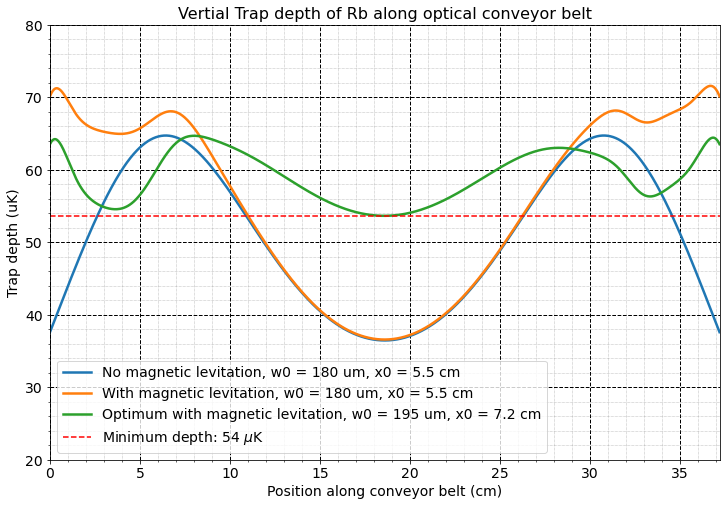

In [104]:
#recompute the vertical trap depth for Rb accounting for magnetic levitation (assume the horizontal trap depth is unaffected). 
#replicates Fig. 2.19(ii) in thesis.

#first, reproduce plot for no magnetic levitation. The optimum parameters are x0 = 5.5 cm and w0 = 180 um.
x01 = 5.5e-2
w01 = 180e-6
x = np.linspace(0,L,1000)
y = 0
z1 = np.linspace(-2*w01,2*w01,1000)
depths = np.empty(len(x))
depths_with_mag = np.empty(len(x))
optimal_depths_with_mag = np.empty(len(x))

x02 = 7.2e-2
w02 = 195e-6
z2 = np.linspace(-2*w02,2*w02,1000)

def U_radial_Rb_with_grav_and_mag_no_cos(z,x,x0,w0,lam,P,a_eff_x):
    return U_radial_Rb_without_grav_no_cos(z,x,x0,w0,lam,P) + m_Rb * a_eff_x * z

#no cos because we only consider trapping at the antinodes of the standing wave
#trap depth in uK
for i in range(len(x)):
    depths[i] = (np.max(U_radial_Rb_with_grav_no_cos(z1,x[i],x01,w01,lam,P)[z<0]) - np.min(U_radial_Rb_with_grav_no_cos(z1,x[i],x01,w01,lam,P)))/k*1e6
    depths_with_mag[i] = (np.max(U_radial_Rb_with_grav_and_mag_no_cos(z1,x[i],x01,w01,lam,P,a_eff[i])[z<0]) - np.min(U_radial_Rb_with_grav_and_mag_no_cos(z1,x[i],x01,w01,lam,P,a_eff[i])))/k*1e6
    optimal_depths_with_mag[i] = (np.max(U_radial_Rb_with_grav_and_mag_no_cos(z2,x[i],x02,w02,lam,P,a_eff[i])[z<0]) - np.min(U_radial_Rb_with_grav_and_mag_no_cos(z2,x[i],x02,w02,lam,P,a_eff[i])))/k*1e6

#plot radial and axial trap depths
min_radial_grav = np.min(optimal_depths_with_mag)

plt.figure(figsize=(12, 8))
plt.plot(x*1e2, depths, label='No magnetic levitation, w0 = 180 um, x0 = 5.5 cm', linewidth=2.5)
plt.plot(x*1e2, depths_with_mag, label='With magnetic levitation, w0 = 180 um, x0 = 5.5 cm', linewidth=2.5)
plt.plot(x*1e2, optimal_depths_with_mag, label='Optimum with magnetic levitation, w0 = 195 um, x0 = 7.2 cm', linewidth=2.5)
plt.axhline(y=min_radial_grav, color='red', linestyle='--', label=f'Minimum depth: {round(min_radial_grav)} $\mu$K')
plt.xlabel('Position along conveyor belt (cm)', fontsize=14)
plt.ylabel('Trap depth (uK)', fontsize=14)
plt.title('Vertial Trap depth of Rb along optical conveyor belt', fontsize=16)
plt.ylim(20, 80)
plt.xlim(0, L*1e2)
plt.legend(fontsize=14)
plt.grid(linestyle = '--', which = 'major', linewidth = 1, color='black')
plt.grid(linestyle = ':', which = 'minor', linewidth = 0.5, color = 'gray')
plt.minorticks_on()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

# Optimize for beam waist (w0) and focus (x0) positions INCLUDING magnetic levitation.
## Compute minimum Rb trap depth (among axial and radial) along transport path.

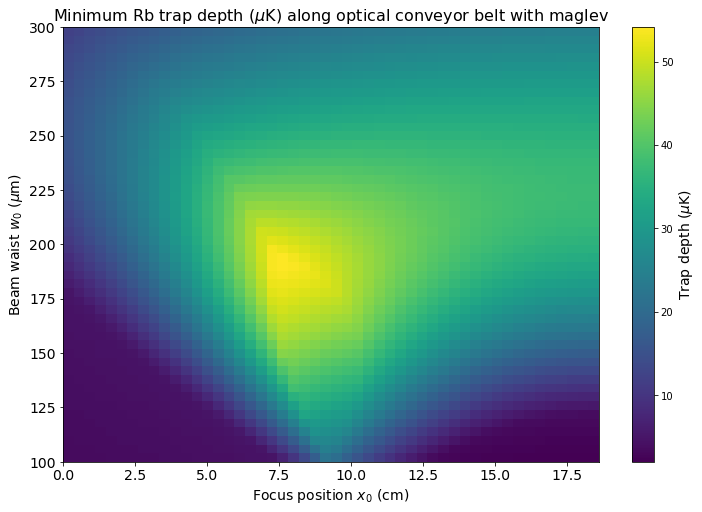

In [105]:
#for a range of beam waists and focus positions, re-compute the minimum trap depth (among radial and axial) - NOW ACCOUNTING FOR MAGNETIC LEVITATION
#along the optical conveyor belt path

x0s = np.linspace(0, 18.6e-2, 50) #in m
w0s = np.linspace(100e-6, 300e-6, 50) #in m
overall_mins = np.empty((len(x0s), len(w0s)))
L = 37.2e-2 #length of conveyor belt in m
lam = 1064e-9 #wavelength of trapping light in m
P = 18 #power of light in W

for i in range(len(x0s)):
    for j in range(len(w0s)):
        x = np.linspace(0,L,1000)
        y = 0
        z = np.linspace(-2*w0s[j],2*w0s[j],1000)
        depths_with_maglev = np.empty(len(x))

        #no cos because we only consider trapping at the antinodes of the standing wave
        for index in range(len(x)):
            depths_with_maglev[index] = (np.max(U_radial_Rb_with_grav_and_mag_no_cos(z1,x[index],x0s[i],w0s[j],lam,P,a_eff[index])[z<0]) - np.min(U_radial_Rb_with_grav_and_mag_no_cos(z1,x[index],x0s[i],w0s[j],lam,P,a_eff[index])))/k*1e6

        min_axial = np.min(U_axial_Rb(x,x0s[i],w0s[j],lam,P))
        min_radial = np.min(U_radial_Rb(x,x0s[i],w0s[j],lam,P))
        min_radial_maglev = np.min(depths_with_maglev)
        overall_min = min(min_axial, min_radial, min_radial_maglev)
        overall_mins[i][j] = overall_min
        #print(overall_mins[i][j], i, j, x0s[i], w0s[j])

overall_mins_final = np.transpose(overall_mins) #rows and cols in 2d matrix plot are flipped
plt.figure(figsize=(12, 8))
plt.imshow(overall_mins_final, extent=[0, 18.6, 100, 300], origin='lower', aspect='auto')
plt.colorbar().set_label('Trap depth ($\mu$K)', fontsize=14)
plt.xlabel('Focus position $x_0$ (cm)', fontsize=14)
plt.ylabel('Beam waist $w_0$ ($\mu$m)', fontsize=14)
plt.title('Minimum Rb trap depth ($\mu$K) along optical conveyor belt with maglev', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

# Compute axial and radial trap frequencies for Rb in presence of gravity and maglev

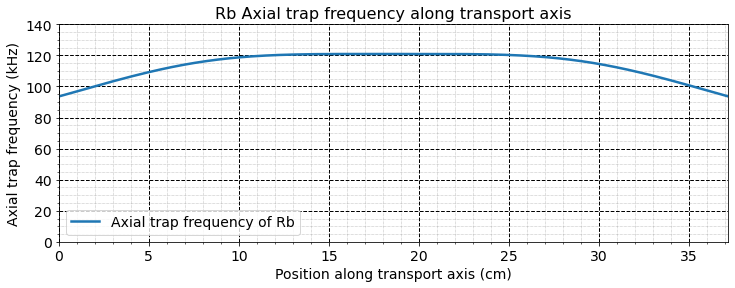

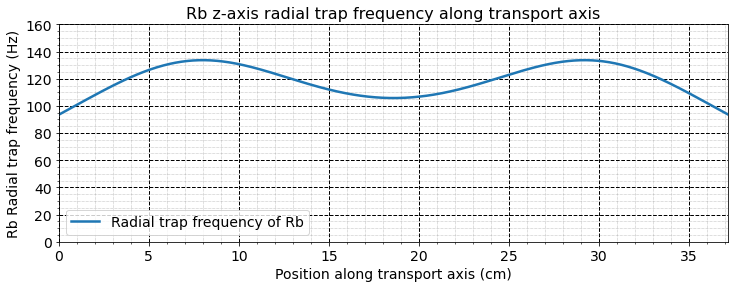

In [106]:
#now, set the optimum focus position and beam waist to the maglev case. We shall compute the trap frequencies in axial and radial directions.
#this reproduces Fig. 4a of the paper and Fig. 2.22 of thesis.

x0mag = 7.2e-2
w0mag = 195e-6

#for a chosen point on the transport axis, plot the axial trap potential (x), radial (y) trap potential, and radial (z, with grav and maglev) trap potential

#axial first
x = 0.25*lam
y = 0
z = 0

xs = np.arange(x, L, 1e3*lam)
axial_freqs = np.empty(len(xs))

#in hindsight I could probably also do this with no cos since we only care about the antinodes?
def U_axial_potential_Rb(x,x0,y,z,w0,lam,P):
    return -(alpha_Rb/(2*epsilon_0*c))*conveyor_intensity(x,x0,y,z,w0,lam,P)

#fit a parabola to the axial potential
def parabola(x, omega, b, c):
    return 0.5*m_Rb*(omega**2)*(x-b)**2 + c

for i in range(len(xs)):
    x_vals = np.linspace(xs[i]+0.18*lam, xs[i]+0.32*lam, 50)
    popt, pcov = curve_fit(parabola, x_vals, U_axial_potential_Rb(x_vals,x0mag,y,z,w0mag,lam,P), p0=[2*np.pi*100e3, xs[i]+0.25*lam, -2e-27])
    axial_freqs[i] = np.abs(popt[0])/(2*np.pi)/1e3

#plt.plot(x_vals, U_axial_potential_Rb(x_vals,x0mag,y,z,w0mag,lam,P), 'o', label='Axial')
#plt.plot(x_vals, parabola(x_vals, *popt), label='Fit')
#plt.legend()
#plt.show()
#print("Axial trap frequency (f) in kHz:", popt[0]/(2*np.pi)/1e3) 

plt.figure(figsize=(12, 4))
plt.plot(xs*1e2, axial_freqs, label='Axial trap frequency of Rb', linewidth=2.5)
plt.xlim(0, L*1e2)
plt.ylim(0, 140)
plt.xlabel('Position along transport axis (cm)', fontsize=14)
plt.ylabel('Axial trap frequency (kHz)', fontsize=14)
plt.title('Rb Axial trap frequency along transport axis', fontsize=16)
plt.grid(linestyle = '--', which = 'major', linewidth = 1, color='black')
plt.grid(linestyle = ':', which = 'minor', linewidth = 0.5, color = 'gray')
plt.minorticks_on()
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

#finally, let's compute the case for the radial trap frequency along the z-axis, with magnetic levitation and gravity
#this reproduces Fig. 4b of the paper and Fig. 2.22 of thesis.

xs = np.linspace(0, L, 1000)
y = 0
zradial_freqs = np.empty(len(xs))

def U_zradial_potential_Rb(x,x0,y,z,w0,lam,P, a_eff_x):
    return -(alpha_Rb/(2*epsilon_0*c))*conveyor_intensity_no_cos(x,x0,y,z,w0,lam,P) + m_Rb * a_eff_x * z

"""
#practice plot of potential in z-direction at x = 5.4e-2 m
xtry = 5.4e-2
zs = np.linspace(-0.25*w0mag, 0.25*w0mag, 50)
popt, pcov = curve_fit(parabola, zs, U_zradial_potential_Rb(xtry,x0mag,y,zs,w0mag,lam,P,a_eff[int(xtry/L*1000)]), p0=[2*np.pi*100, 0.001*w0mag, -2e-27])
plt.plot(zs*1e6, U_zradial_potential_Rb(xtry,x0mag,y,zs,w0mag,lam,P,a_eff[int(xtry/L*1000)]), 'o')
plt.plot(zs*1e6, parabola(zs, *popt))
plt.show()

print("z-radial trap frequency (f) in Hz:", popt[0]/(2*np.pi))
"""

for i in range(len(xs)):
    z_vals = np.linspace(-0.25*w0mag, 0.25*w0mag, 50)
    popt, pcov = curve_fit(parabola, z_vals, U_zradial_potential_Rb(xs[i],x0mag,y,z_vals,w0mag,lam,P,a_eff[i]), p0=[2*np.pi*100, 0.001*w0mag, -2e-27])
    zradial_freqs[i] = np.abs(popt[0])/(2*np.pi)

plt.figure(figsize=(12, 4))
plt.plot(xs*1e2, zradial_freqs, label='Radial trap frequency of Rb', linewidth=2.5)
plt.xlim(0, L*1e2)
plt.ylim(0, 160)
plt.xlabel('Position along transport axis (cm)', fontsize=14)
plt.ylabel('Rb Radial trap frequency (Hz)', fontsize=14)
plt.title('Rb z-axis radial trap frequency along transport axis', fontsize=16)
plt.grid(linestyle = '--', which = 'major', linewidth = 1, color='black')
plt.grid(linestyle = ':', which = 'minor', linewidth = 0.5, color = 'gray')
plt.minorticks_on()
plt.legend(fontsize=14, loc='lower left')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()